In [50]:
import math
import numpy as np
import random
import time
import pickle


class Flight:
    def __init__(self):
        # Constants
        self.g = 9.81  # m/s^2
        self.fuel_m = 20100 / 1.2  # Mass of fuel; kg
        self.m = 60000 + self.fuel_m  # kg
        self.initial_mass = 60000 + self.fuel_m  # kg
        self.flap_factor = 1.5  # Flap factor
        self.max_cl = 0.5  # Lift coefficient
        self.min_cd = 0.05  # Drag coefficient
        self.cruise_altitude = 10000  # m
        self.air_density = 1.225  # kg/m^2
        self.wing_SA = 2 * 125  # Wing surface area; m^2
        self.frontal_SA = 3.76 * 4  # Frontal surface area; m^2
        self.underbelly_SA = 32 * 3.76  # Underbelly surface area; m^2
        self.Vc = 258  # Critical airplane speed; m/s
        self.Vs = 343  # Speed of sound; m/s
        self.Mc = 0.78  # Critical Mach number
        self.max_T = 2 * 146346  # N
        self.SFC = 0.627  # Specific fuel consumptionl lb/(lbf.h)

        # Dynamics
        self.T = [0.0, 0.0]  # N
        self.P = [(0.0, 1.0)]  # m
        self.V = [(68.768, 9.665)]  # m/s
        self.A = [(0.0, 0.0)]  # m/s^2
        self.dt = 0.02  # s

        # Storing values
        self.cl_list = []
        self.cd_list = []
        self.theta_list = []
        self.gamma_list = []
        self.alpha_list = []
        self.SA_perp_list = []
        self.SA_parallel_list = []
        self.m_list = [self.m]
        self.fuel_m_list = [self.fuel_m]
        self.cruising_index = None

    # Calculate temperature
    def temp(self, h):
        return (15.04 - 0.00649 * h if h < 11000 else -56.46) + 273.15

    # Calculate the change in fuel
    def fuel_consumption(self, h, V, T):
        fuel_m_dot = (3.338 * 10**(-8) * np.linalg.norm(V) +
                      1.04 * 10**(-5) * math.sqrt(288.15 / self.temp(h))) * T
        fuel_m_change = fuel_m_dot * self.dt
        return fuel_m_change

    # Get Mach number
    def M(self, vx):
        return vx / self.Vs

    # Slope of climb
    def gamma(self, v_components):
        V = np.linalg.norm(v_components)
        return 0 if V <= 0 else np.arcsin(v_components[1] / V)

    # Angle of attack
    def alpha(self, gamma, theta):
        return theta - gamma

    # Surface area orthogonal to the speed vector
    def SA_perp(self, alpha):
        alpha = np.abs(alpha)
        return (self.wing_SA + self.underbelly_SA
                ) * math.sin(alpha) + self.frontal_SA * math.cos(alpha)

    # Surface area parallel to the speed vector
    def SA_parallel(self, alpha):
        alpha = np.abs(alpha)
        return (self.wing_SA + self.underbelly_SA
                ) * math.cos(alpha) + self.frontal_SA * math.sin(alpha)

    # Lift coefficient based on Mach number
    def mach_cl(self, cl, vx):
        M = self.M(vx)
        if M <= self.Mc:
            return cl

        Mdd = self.Mc + (1 - self.Mc) / 4
        return (cl + 0.1 * (M - self.Mc) if M <= Mdd else cl + 0.1 *
                (Mdd - self.Mc) - 0.8 * (M - Mdd))

    # Drag coefficient based on Mach number
    def mach_cd(self, cd, vx):
        M = self.M(vx)
        if M < self.Mc:
            return cd / math.sqrt(1 - (M**2))
        return cd * 15 * (M - self.Mc) + cd / math.sqrt(1 - self.Mc**2)

    # Lift coefficient
    def cl(self, alpha, vx):
        alpha += np.radians(5)
        sign = np.sign(np.degrees(alpha))
        degrees = np.abs(np.degrees(alpha))

        cl = 0
        if degrees < 15:
            cl = np.degrees(alpha) * self.max_cl / 15
        elif np.abs(degrees) < 20:
            cl = np.abs((1 - (np.degrees(alpha) - 15) / 15) * self.max_cl)

        cl *= sign
        return self.mach_cl(cl, vx)

    # Drag coefficient
    def cd(self, alpha, vx):
        return self.mach_cd((np.degrees(alpha) * 0.02)**2 + self.min_cd, vx)

    def altitude_factor(self, Py):
        x = 1 / math.exp(Py / 7500)
        return max(0, min(1, x**0.7))

    # Drag/lift force
    def drag_lift(self, S, V, C, Py):
        return self.air_density * self.altitude_factor(Py) * C * S * V**2 / 2

    # Calculate new acceleration
    def get_acceleration(self, T, theta, v_components, mass, Py):
        # Angles
        gamma = self.gamma(v_components)
        alpha = self.alpha(gamma, theta)

        # Properties
        weight = self.g * mass
        SA_perp = self.SA_perp(alpha)
        SA_parallel = self.SA_parallel(alpha)
        cl = self.cl(alpha, v_components[0])
        cd = self.cd(alpha, v_components[0])

        # Lift and drag forces
        V = np.linalg.norm(v_components)
        Fd = self.flap_factor * self.drag_lift(SA_perp, V, cd, Py)
        Fl = self.flap_factor * self.drag_lift(SA_parallel, V, cl, Py)

        # Horizontal force
        Fx = math.cos(theta) * T - math.sin(theta) * \
            Fl - np.abs(math.cos(gamma) * Fd)

        # Verticle force
        Fy = math.sin(theta) * T + math.cos(theta) * \
            Fl - math.sin(gamma) * Fd - weight

        # Acceleration
        A = (Fx / mass, Fy / mass)

        # Storing values
        # self.cl_list.append(cl)
        # self.cd_list.append(cd)
        # self.gamma_list.append(gamma)
        # self.alpha_list.append(alpha)
        # self.SA_perp_list.append(SA_perp)
        # self.SA_parallel_list.append(SA_parallel)

        # Return current acceleration
        return A

    # Calculate new velocity
    def get_velocity(self, curr_velocity, acceleration):
        return (
            curr_velocity[0] + acceleration[0] * self.dt,
            curr_velocity[1] + acceleration[1] * self.dt,
        )

    # Calculate new position
    def get_position(self, p, v):
        return (p[0] + v[0] * self.dt, p[1] + v[1] * self.dt)

    # Calculate the net thrust experinced
    def percent_thrust_conversion(self, percent_thrust, Py):
        return percent_thrust * self.max_T * self.altitude_factor(Py)

    # Flight dynamics
    def dynamics(self, T, theta):
        T_actual = self.percent_thrust_conversion(T, self.P[-1][1])

        curr_mass = self.m_list[-1]

        self.A.append(
            self.get_acceleration(T_actual, theta, self.V[-1], curr_mass,
                                  self.P[-1][1]))
        self.V.append(self.get_velocity(self.V[-1], self.A[-1]))
        self.P.append(self.get_position(self.P[-1], self.V[-2]))

        fuel_change = self.fuel_consumption(self.P[-1][1], self.V[-1],
                                            T_actual)

        self.fuel_m_list.append(self.fuel_m_list[-1] - fuel_change)

        # Storing values
        self.m_list.append(curr_mass - fuel_change)

    def update_vectors(self, change_index, change_theta, change_thrust):
        new_T = self.T[:]
        new_A = self.A[:]
        new_V = self.V[:]
        new_P = self.P[:]
        new_theta = self.theta_list[:]
        new_fuel_m_list = self.fuel_m_list[:]
        new_m_list = self.m_list[:]

        cruising_index = None

        for i in range(change_index[0], change_index[1]):
            new_T[i] = change_thrust
            new_theta[i] = np.radians(change_theta)

        for i in range(change_index[0], len(new_T)):
            curr_thrust_percentage = new_T[i]
            curr_thrust = self.percent_thrust_conversion(
                curr_thrust_percentage, new_P[i - 1][1])
            curr_theta = new_theta[i]
            new_A[i] = self.get_acceleration(
                curr_thrust,
                curr_theta,
                new_V[i - 1],
                new_m_list[i - 1],
                new_P[i - 1][1],
            )
            new_V[i] = self.get_velocity(new_V[i - 1], new_A[i - 1])
            new_P[i] = self.get_position(new_P[i - 1], new_V[i - 1])
            
            if cruising_index is None and (new_P[i][1] >= self.cruise_altitude):
                cruising_index = i
                

            fuel_change = self.fuel_consumption(new_P[i][1], new_V[i],
                                                curr_thrust)
            new_fuel_m_list[i] = new_fuel_m_list[i - 1] - fuel_change
            new_m_list[i] = new_m_list[i - 1] - fuel_change

        update_package = {
            "T": new_T,
            "A": new_A,
            "V": new_V,
            "P": new_P,
            "theta_list": new_theta,
            "fuel_m_list": new_fuel_m_list,
            "m_list": new_m_list,
            "cruising_index": cruising_index
        }

        return update_package


    def update_with_package(self, update_package):
        self.T = update_package["T"]
        self.A = update_package["A"]
        self.V = update_package["V"]
        self.P = update_package["P"]
        self.theta_list = update_package["theta_list"]
        self.fuel_m_list = update_package["fuel_m_list"]
        self.m_list = update_package["m_list"]
        self.cruising_index = update_package["cruising_index"]

    def main(self, duration, theta, thrust_percent):
        time_range = np.arange(0, duration, self.dt)
        self.time_range_len = len(time_range)
        self.T = [thrust_percent] * len(time_range)
        self.theta_list = [np.radians(theta)] * len(time_range)

        for index in range(self.time_range_len - 1):
            curr_T = self.T[index]
            curr_theta = self.theta_list[index]
            self.dynamics(curr_T, curr_theta)
            if self.cruising_index is None and (self.P[index][1] >= self.cruise_altitude):
                self.cruising_index = index


class Simulation:
    def __init__(self, model):
        self.model = model
        self.change_percentage = 0.02
        self.target_altitude = 10000

    def random_indicies(self, change_length):
        starting_index = random.choice(
            range(1, self.model.time_range_len - change_length - 1))

        return (starting_index, starting_index + change_length)
    
    def random_thrusts(self, curr_thrusts):
        avg_thrusts = sum(curr_thrusts)/len(curr_thrusts)
        results = []
        if avg_thrusts > 0 and (avg_thrusts - 0.25 * avg_thrusts) > 0:
            results.append((avg_thrusts - 0.25 * avg_thrusts))
        if avg_thrusts < 1 and (avg_thrusts + 0.25 * avg_thrusts) < 1:
            results.append((avg_thrusts + 0.25 * avg_thrusts))
        
        return results
    
    def random_angles(self, curr_angles):
        curr_angles = np.array(curr_angles)
        avg_angles = np.sum(np.degrees(curr_angles))/len(curr_angles)
        results = []
        if avg_angles > 0 and (avg_angles - 0.20) > 0:
            results.append(np.radians(avg_angles - 0.20))
        if avg_angles < 25 and (avg_angles + 0.20) < 25 :
            results.append(np.radians(avg_angles + 0.20))
        return results
    
    def simulated_annealing(self, max_temp, n_steps):
        most_recent_update = None
        for step in range(n_steps):
            curr_temp = max_temp * np.exp(-step / (n_steps * 0.1))
            change_range = self.random_indicies(
                int(self.model.time_range_len * self.change_percentage))
#             curr_thrusts = self.model.T[change_range[0] : change_range[1]]
#             curr_angles = self.model.theta_list[change_range[0] : change_range[1]]
            
#             new_thurst = random.choice(self.random_thrusts(curr_thrusts))
#             new_angle = random.choice(self.random_angles(curr_angles))

            new_thurst = random.random()
            new_angle = random.random() * 20

            results = flight.update_vectors(change_range, new_angle,
                                            new_thurst)
            
            if results["cruising_index"] is not None:
                old_cost = self.cost(self.model.fuel_m_list, self.model.cruising_index)
                new_cost = self.cost(results["fuel_m_list"], results["cruising_index"])

                change = abs(new_cost - old_cost)
                prob = np.exp(-change / curr_temp)
                if results["P"][-1][1] > self.model.cruise_altitude:
                    if new_cost < old_cost or random.random() < prob:
                        self.model.update_with_package(results)
                        most_recent_update = results
            if (step % 50) == 0:
                print(step)
                print(self.cost(self.model.fuel_m_list, self.model.cruising_index), self.model.P[self.model.cruising_index],self.model.P[-1])
            if step == (n_steps - 1):
                print(step)
                print(self.cost(self.model.fuel_m_list, self.model.cruising_index), self.model.P[self.model.cruising_index],self.model.P[-1])

        pickle.dump(most_recent_update, open("update_package", "wb"))

    def cost(self, fuel_m_list, idx):
        return fuel_m_list[0] - fuel_m_list[idx]

In [53]:
flight = Flight()
flight.main(600, 5, 1)

print(flight.P[-1])

print(flight.fuel_m_list[0] - flight.fuel_m_list[flight.cruising_index])

(140476.3093581849, 17032.207211591813)
1132.557667916728


In [ ]:
s = Simulation(flight)

start_time = time.time()
s.simulated_annealing(100, 20000)
print(time.time() - start_time)





0
1099.0054941450744 (59070.50012872359, 10000.465814669675) (112165.9138690448, 15728.480181871551)
50
1105.0772777937618 (67609.03788741292, 10000.357951171572) (97169.21699401071, 13039.543903642336)
100
1143.8840868725456 (71322.35398182686, 10000.026343416013) (79592.12186098196, 10030.927211711665)
150
1143.8970333102843 (81268.71452342613, 10000.213848441861) (86783.41413482346, 10005.425917026372)
200
1180.081718241352 (79779.40308402403, 10000.017693078049) (83369.54253619054, 10104.190568610293)
250
1159.1791919869593 (79105.2120301215, 10000.222197428817) (82134.89122896733, 10002.235835359234)
300
1121.6992851347022 (78124.98515391436, 10124.930347731788) (81001.71492146417, 10140.712456187724)
350
1156.136980791658 (82237.81605825733, 10000.343037716228) (85918.04705781322, 10420.933251117664)
400
1120.5578787842624 (80380.21532152282, 10000.610539745432) (84756.25851142351, 10449.163575673421)
450
1150.4165822725226 (78057.01675354478, 10000.407224954582) (80179.738018112

In [107]:
print(s.model.P[-1])
opened =  pickle.load(open('update_package', "rb"))
print(opened['P'][-1])

(102544.23457631133, 10015.75485497467)
(102544.23457631133, 10015.75485497467)


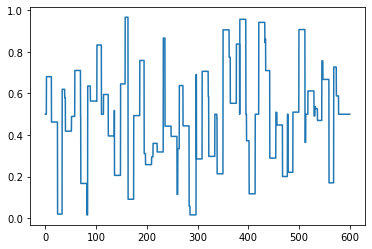

In [36]:
import matplotlib.pyplot as plt

plt.plot(np.arange(0,600,0.1), s.model.T)
# plt.plot(np.arange(0,600,0.1), np.degrees(np.array(s.model.theta_list)))

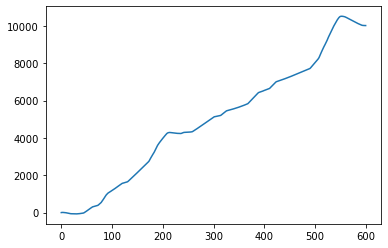

In [110]:
plt.plot(np.arange(0,600,0.1), [i[1] for i in s.model.P])

In [9]:
print(s.model.P)

[(0.0, 1.0), (1.315, 1.115), (2.630972419909803, 1.2287931278442934), (3.9479135404046892, 1.3414120828790799), (5.265819720861743, 1.4528888582123378), (6.5846873977847284, 1.5632547549822386), (7.904513083265854, 1.6725403963669556), (9.225293363482807, 1.7807757413395864), (10.547024897229543, 1.8879900981718913), (11.869704414479433, 1.994212137690529), (13.193328714979481, 2.0994699062894497), (14.517894666874394, 2.2037908387020804), (15.843399205359383, 2.307201770536914), (17.169839331360674, 2.409728950580088), (18.49721211024274, 2.5113980528685085), (19.825514670541363, 2.6122341885370504), (21.154744202721687, 2.7122619174433327), (22.484897957960474, 2.811505259573541), (23.815973246951835, 2.9099877062327337), (25.147967438735755, 3.007732231023045), (26.480877959548778, 3.104761300613153), (27.814702291696243, 3.201096885302366), (29.149437972445504, 3.2967604693826305), (30.485082592939648, 3.3917730613017416), (31.821633797131152, 3.486155203630998), (33.15908928073507

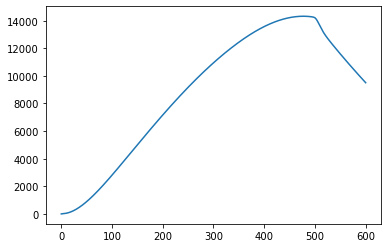

In [49]:


# tester = Flight()
# tester.main(600, 25, 1)

plt.plot(np.arange(0,600,0.01), [i[1] for i in flight.P])